# Derivation of data with noise


.. codeauthor:: Emile Roux emile.roux@univ-smb.fr

.. This notebook is ready for  [RISE](https://damianavila.github.io/RISE/) Slideshow

## Scope

* Finite number $N$ of data points $(x,y)$ are available, this data include noise: compute the derivative $\dfrac{dx}{dy}$



In [1]:
# Setup
%load_ext autoreload
%matplotlib nbagg
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib as mpl
from PIL import Image # On charge Python Image Library
from matplotlib import pyplot as plt # On charge pyplot (un sous module de Matplotlib) et on le renomme plt
from matplotlib import cm
from scipy import ndimage
from scipy import interpolate
from scipy import signal

import gpxpy
import gpxpy.gpx
from geopy.distance import great_circle, vincenty


## Introduction
To adress the problem of derivative comptatio of noisy data we proposed to analysed GPS data of hiking in the alpen.

Gps postion are subject to noise, this noise is due to the accuracy of the GPS.



## A class to read data form [Earthexplorer](https://earthexplorer.usgs.gov/)
This class manipulates elavation map comming from [Earthexplorer](https://earthexplorer.usgs.gov/) (login requiered). 
The supported format is : digital  elevation /aster global dem, in geotiff format
1pix = 1 arc second


In [2]:
class ElevMap:
    """
    This class manipulates elavation map comming from https://earthexplorer.usgs.gov/.
    The supported format is : digital  elevation / SRMT 1 arc-seconde global
    Where 1pix = 1 arc second
    """
    def __init__(self, file_name):
        self.file_name = file_name
        self.read_elevation_from_file()
        
    
    #https://librenepal.com/article/reading-srtm-data-with-python/    
    def read_elevation_from_file(self):
        SAMPLES = 3601 # Change this to 3601 for SRTM1
        with open(self.file_name, 'rb') as hgt_data:
            # Each data is 16bit signed integer(i2) - big endian(>)
            elevations = np.fromfile(hgt_data, np.dtype('i2'), SAMPLES*SAMPLES).reshape((SAMPLES, SAMPLES))

        self.elevations = elevations[4:,4:].astype(np.float64)

        # Creat the grid of coordonee associated with the elevation map
        Nx,Ny = self.elevations.shape
        cor=self.file_name.split("_")[-2]
        N=float(cor[1:3])
        E=float(cor[4:])
        x = np.linspace(E, E + 1, Nx)
        y = np.linspace(N + 1, N, Ny)
        self.Xg, self.Yg = np.meshgrid(x, y)

        self.aspect = great_circle((self.Yg[0,0] ,self.Xg[0,0]) , (self.Yg[-1,0] ,self.Xg[-1,0])).km / great_circle((self.Yg[0,0] ,self.Xg[0,0]) , (self.Yg[0,-1] ,self.Xg[0,-1])).km

        
    def plot(self,ax):
        cs = ax.contourf(self.Xg, self.Yg, self.elevations , vmin=0, vmax=4808) 
        ax.set_aspect(aspect=self.aspect)
        return cs
 

    def plot_track(self,ax, df):
        mask = np.ones(self.Xg.shape)

        large = .03
        mask[np.where(self.Xg  < df.long.min() - large  )]=np.nan
        mask[np.where(self.Xg  > df.long.max() + large )]=np.nan

        mask[np.where(self.Yg < df.lat.min() - large )]=np.nan
        mask[np.where(self.Yg > df.lat.max() + large )]=np.nan
         
        cs = ax.contourf(self.Xg , self.Yg , self.elevations*mask ) 
        plt.plot(df.long,df.lat,'r',label = "path")
        ax.set_aspect(aspect=self.aspect)
        
        ax.set_xlim(df.long.min() - large  , df.long.max() + large )
        ax.set_ylim(df.lat.min()  - large  , df.lat.max()  + large )
        
        return cs

### Some cities to plot on top of the map

In [3]:
site_coord=np.array([[6.865133,45.832634],[ 6.157845,45.919490],[6.389560,45.663787], [6.864840,45.916684],[6.633973,45.935047],[6.672323,45.200746],[ 6.425097, 45.904318]]) 
site_name = ["Mont Blanc", "Polytech", "Albertville","Chamonix",'Sallanches', "Modane","La Cluzas"]

## Read a map elevation

In [4]:
M1 = ElevMap('.\_DATA\ASTGTM2_N45E006_dem.tif')
#M2 = ElevMap('.\_DATA\ASTGTM2_N46E007_dem.tif')
#M3 = ElevMap('.\_DATA\ASTGTM2_N45E007_dem.tif')
#M4 = ElevMap('.\_DATA\ASTGTM2_N46E006_dem.tif')

## Plot the data

<IPython.core.display.Javascript object>


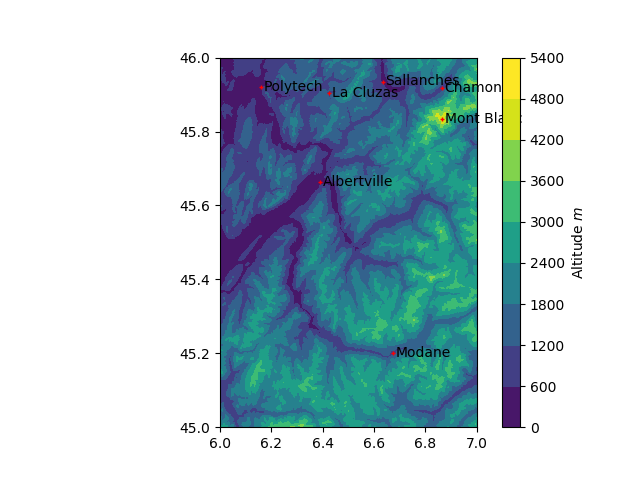

In [5]:
fig = plt.figure()
ax = fig.gca()
#M2.plot(ax)
#M3.plot(ax)
#M4.plot(ax)
cs=M1.plot(ax)

cbar = fig.colorbar(cs)
cbar.set_label('Altitude $m$')   # On specifie le label en z

ax.plot(site_coord[:,0],site_coord[:,1],'r+',markersize=3)
for i, txt in enumerate(site_name):
    ax.annotate(txt, (site_coord[i,0]+.01,site_coord[i,1]-0.01))
    
plt.show()

## GPS point data set
The gpx format is a standar format. 

The pygpx module is used to imoprt the data (https://pypi.python.org/pypi/gpxpy)

In [6]:
gpx_file = open( './_DATA/activity_Raquette.gpx', 'r' )

### Parse the gpx data to make a pandas dataframe of it

#### Parse the gpx file

In [7]:
gpx = gpxpy.parse(gpx_file)

#### Initiate the pandas dataframe

In [8]:
df = pd.DataFrame([] , index = [], columns = ['time','seconde', 'lat', 'long','elevation','dist'])

#### Fullfill the dataframe with the gpx data

In [9]:
i=0
t0 = gpx.tracks[0].segments[0].points[0].time
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            if i==0:
                df.loc[i]=[(point.time-t0),(point.time-t0).seconds,point.latitude, point.longitude, point.elevation,0.]
            else:
                dist = df.dist[i-1] + great_circle((point.latitude,point.longitude) , (df.lat[i-1],df.long[i-1])).km*1000.
                df.loc[i]=[(point.time-t0),(point.time-t0).seconds,point.latitude, point.longitude, point.elevation,dist]
            i=i+1


#### Display the dataframe

In [10]:
df.head(30)

time seconde        lat      long    elevation       dist
0  00:00:00       0  45.889134  6.451944  1761.599976   0.000000
1  00:00:01       1  45.889134  6.451944  1761.599976   0.055937
2  00:00:03       3  45.889138  6.451947  1761.199951   0.561099
3  00:00:06       6  45.889148  6.451971  1761.400024   2.746140
4  00:00:07       7  45.889151  6.451982  1761.800049   3.594090
5  00:00:08       8  45.889153  6.451989  1762.199951   4.204322
6  00:00:09       9  45.889156  6.451997  1762.599976   4.936265
7  00:00:10      10  45.889159  6.452006  1763.199951   5.693639
8  00:00:11      11  45.889161  6.452014  1763.400024   6.337976
9  00:00:17      17  45.889176  6.452063  1763.400024  10.514476
10 00:00:22      22  45.889187  6.452107  1763.400024  14.115267
11 00:00:28      28  45.889204  6.452154  1763.599976  18.182346
12 00:00:29      29  45.889206  6.452160  1764.000000  18.697474
13 00:00:30      30  45.889208  6.452169  1764.400024  19.448647
14 00:00:31      31  45.889210  6.452177  1764.800049  20.132073
15 00:00:32      32  45.889212  6.452189  1765.199951  21.071081
16 00:00:33      33  45.889212  6.452194  1765.400024  21.495445
17 00:00:36      36  45.889214  6.452223  1765.400024  23.698945
18 00:00:42      42  45.889233  6.452275  1765.400024  28.232220
19 00:00:44      44  45.889238  6.452297  1765.800049  30.061939
20 00:00:45      45  45.889239  6.452298  1766.199951  30.203330
21 00:00:46      46  45.889245  6.452316  1766.599976  31.733769
22 00:00:47      47  45.889242  6.452318  1767.000000  32.014060
23 00:00:48      48  45.889249  6.452334  1767.400024  33.435011
24 00:00:49      49  45.889252  6.452340  1767.400024  34.015566
25 00:00:55      55  45.889263  6.452388  1767.400024  37.907578
26 00:00:58      58  45.889272  6.452408  1767.800049  39.750404
27 00:00:59      59  45.889274  6.452418  1768.199951  40.580836
28 00:01:00      60  45.889276  6.452420  1768.599976  40.820970
29 00:01:01      61  45.889278  6.452433  1769.000000  41.842973

### Plot the track

<IPython.core.display.Javascript object>


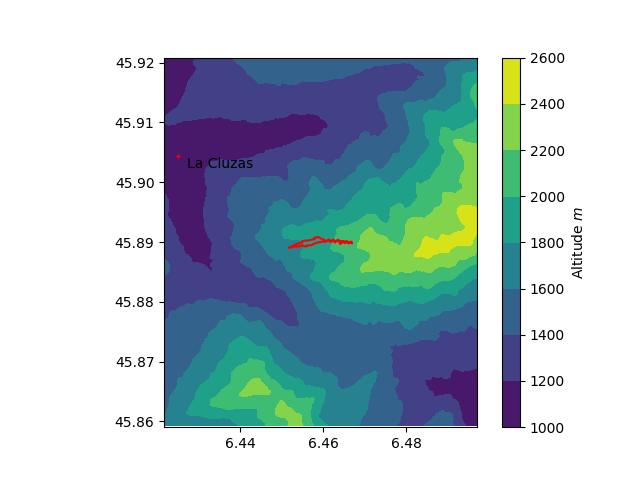

In [11]:
fig = plt.figure()
ax = fig.gca()
cs = M1.plot_track(ax,df)
cbar = fig.colorbar(cs)
cbar.set_label('Altitude $m$')   # On specifie le label en z

ax.plot(site_coord[:,0],site_coord[:,1],'r+',markersize=3)
for i, txt in enumerate(site_name):
    ax.annotate(txt, (site_coord[i,0]+.002,site_coord[i,1]-0.002))

### Plot the elevation vs. distance

<IPython.core.display.Javascript object>


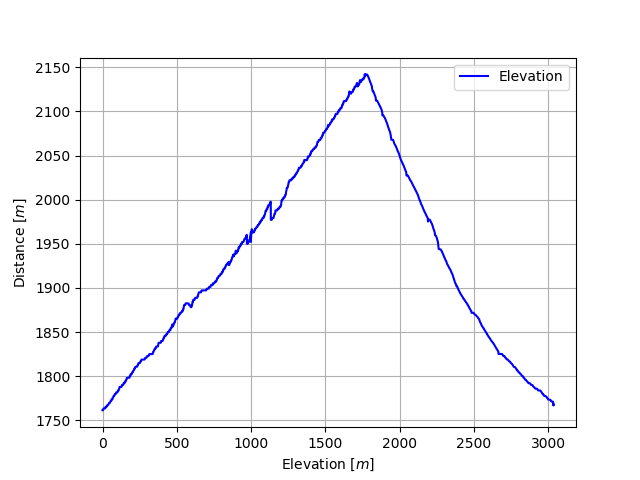

In [12]:
fig = plt.figure()
plt.plot(df.dist,df.elevation,'b',label = "Elevation")
plt.ylabel("Distance [$m$]")
plt.xlabel("Elevation [$m$]")
plt.grid()
plt.legend()
plt.show()

### Plot the distance vs. time

<IPython.core.display.Javascript object>


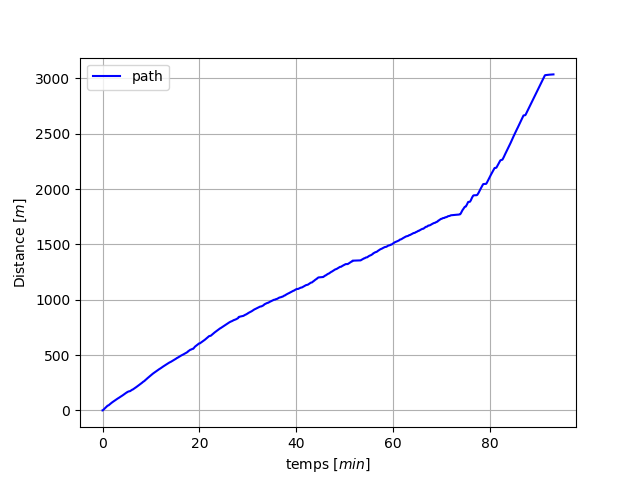

In [13]:
fig = plt.figure()
plt.plot(df.seconde/60,df.dist,'b',label = "path")
plt.xlabel("temps [$min$]")
plt.ylabel("Distance [$m$]")
plt.grid()
plt.legend()
plt.show()

## How to compute the velocity during the snow shoes hicking ?

We know that to get the velocity, we just have to compute the derivative of the distance respect to time.

To performe this derivative the reader can refer to the notebook "Derivation of numerical data"


In [14]:
vit = np.diff(df.dist)/np.diff(df.seconde)
vit = vit * 3.6 # m/s to km/h

### Plot the velocity vs. time

<IPython.core.display.Javascript object>


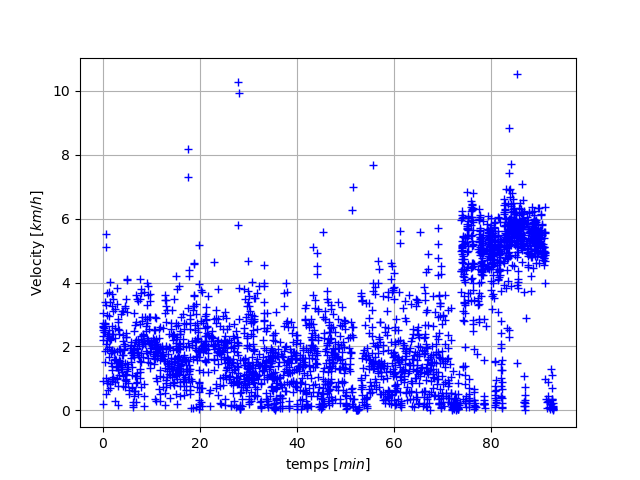

In [15]:
fig = plt.figure()
plt.plot(df.seconde[:-1]/60,vit,'+b')
plt.xlabel("temps [$min$]")
plt.ylabel("Velocity [$km/h$]")
plt.grid()
plt.show()

The obtained results is no readable and give no valuable information !


In [16]:
skip = 5
vit = np.diff(signal.savgol_filter(df.dist[::skip] , 41, 2))/np.diff(df.seconde[::skip])
vit = signal.savgol_filter(df.dist , 101, 1, deriv=1, delta = 1) 
vit = vit * 3.6 # m/s to km/h

<IPython.core.display.Javascript object>


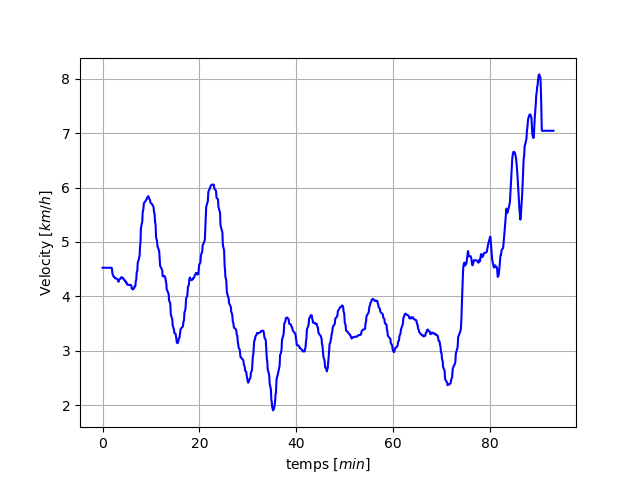

In [17]:
fig = plt.figure()
plt.plot(df.seconde/60,vit,'b')
plt.xlabel("temps [$min$]")
plt.ylabel("Velocity [$km/h$]")
plt.grid()
plt.show()